# LEADING Boot-Camp: Deep Learning


In [1]:
# Common imports
import numpy as np
import pandas as pd

# To plot figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

First let's import TensorFlow and Keras, and check versions.

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.3.1'

In [4]:
keras.__version__

'2.4.0'

`-tf` indicates `tf.keras` implements the Keras API, and some extra TensorFlow-specific features.

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

## 1. Building an Image Classifier Using Sequential API
Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, the testing set contains 10,000 grayscle images. Each image has 28x28 pixels.

In [7]:
X_train_full.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Each pixel intensity is represented as a byte (0 to 255), integers.

In [8]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a (smaller) training set and a validation set. 

Rescale the pixels intensities to [0,1] for all datasets. 

In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

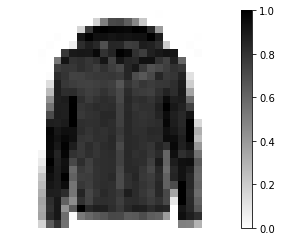

In [10]:
plt.imshow(X_train[0], cmap=plt.cm.binary)
plt.axis('off')
plt.colorbar()
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [11]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [12]:
np.bincount(y_train)

array([5543, 5444, 5496, 5499, 5512, 5507, 5507, 5488, 5510, 5494])

Here is the [link](https://www.tensorflow.org/tutorials/keras/classification) with corresponding class names information. 

In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [14]:
class_names[y_train[0]]

'Coat'

The training set contains 55,000 images, validation set contains 5,000 images, and the test set contains 10,000 images.

In [15]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

Let's take a look at a sample of the images in the dataset:

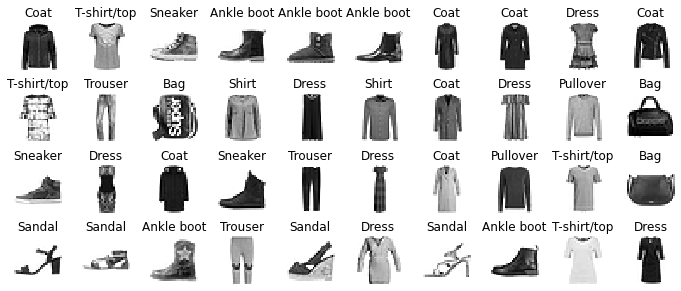

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap=plt.cm.binary, interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Creating the model using the Sequential API

Classification MLP with two hidden layers:

In [17]:
# creates a Sequential model, compsed of a single stack of layers connected sequentially
model = keras.models.Sequential()

# convert input into 1D array, same as use Inputlayer
# model.add.(keras.layers.InputLayer(input_shape=[28, 28]))
model.add(keras.layers.Flatten(input_shape=[28, 28]))

# add two dense hidden layers
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))

# dense output layer, each class has one neuron
model.add(keras.layers.Dense(10, activation="softmax"))

Instead of add layers one by one, can also pass a list of layers when creating Sequential model:

```python
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
```

In [18]:
keras.backend.clear_session()

The model’s `summary()` method displays all the model’s layers, including each layer’s name, its output shape (None means the batch size can be anything), and its number of parameters. 

The summary ends with the total number of parameters, including trainable and non-trainable parameters. 

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Dense layers often have a lot of parameters. 
* The first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters;
* The second hidden layer has 300 x 100 connection weights, plus 100 bias terms, which adds up to 30,100 parameters;
* The third hidden layer has 100 x 10 connection weights, plus 10 bias terms, which adds up to 1,010 parameters.

The large number of parameters gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.

In [20]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


To fetch a layer by index:

In [21]:
model.layers

In [22]:
hidden1 = model.layers[1]
print(hidden1.name)
print(model.layers[2].name)

dense
dense_1


In [23]:
model.get_layer('dense_2')

All the parameters of a layer can be accessed using its `get_weights()` and `set_weights()` methods. For a Dense layer, this includes both the connection weights and the bias terms:

In [24]:
weights, biases = hidden1.get_weights()

In [25]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [26]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
weights.shape, biases.shape

((784, 300), (300,))

Notice that the Dense layer initialized the connection weights randomly, and the biases were initialized to zeros. 

If you ever want to use a different initialization method, you can set `kernel_initializer` (kernel is another name for the matrix of connection weights) or `bias_initializer` when creating the layer. More details can be found in [here](https://keras.io/initializers).

The shape of the weight matrix depends on the number of inputs. If you know the input shape when creating the model, it is best to specify it.

#### Compilng the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

* Loss function : to measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* Optimizer: to indicates how the model is updated based on the data it sees and its loss function.
* Metrics: to monitor the training and testing steps. 

Optionally, you can specify a list of extra metrics to compute during training and evaluation.

You can also check the full list of [loss functions](https://keras.io/losses), [optimizers](https://keras.io/optimizers), and [metrics](https://keras.io/metrics).

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

#### Training and evaluating the model

Instead of passing a validation set using the validation_data argument, you could set `validation_split` to the ratio of the training set that you want Keras to use for validation.

In [29]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4393 - accuracy: 0.8455 - val_loss: 0.5288 - val_accuracy: 0.8002
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4126 - accuracy: 0.8564 - val_loss: 0.3915 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3940 - accuracy: 0.8621 - val_loss: 0.3753 - val_accuracy: 0.8684
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3752 - accuracy: 0.8677 - val_loss: 0.3712 - val_accuracy: 0.8720
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3634 - accuracy: 0.8712 - val_loss: 0.3620 - val_accuracy:

The `fit()` method returns a History object:
* training parameters: `history.params`
* epochs it went through `history.epoch`
* most importantly a dictionary `history.history` containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set. 

In [30]:
print('training parameters:', history.params)
print()
print('training epoch:', history.epoch)
print()
print('training metrics:', history.history.keys())

training parameters: {'verbose': 1, 'epochs': 30, 'steps': 1719}

training epoch: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

training metrics: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [31]:
df = pd.DataFrame(history.history)
df['val_loss'] = df['val_loss'].shift(1)
df['val_accuracy'] = df['val_accuracy'].shift(1)

In [32]:
# visualize
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Training epoch #', fontsize = 15)
plt.ylabel('Metrics value', fontsize = 15)
plt.legend(fontsize = 12)
plt.show()

In [33]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 620us/step - loss: 0.3372 - accuracy: 0.8817


[0.3371742069721222, 0.8816999793052673]

#### Using the model to make predictions

In [34]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [35]:
y_pred = model.predict_classes(X_new)
np.array(class_names)[y_pred]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [36]:
np.array(class_names)[y_test[:3]]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [37]:
plt.figure(figsize=(6, 2))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.show()

## 2. Building a Regression MLP using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [38]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Using the Sequential API to build, train, evaluate, and use a regression MLP to make predictions is quite similar to what we did for classification. 

The main differences are:
* the output layer has a single neuron and uses no activation function
* the loss function is the mean squared error. 
* use a single hidden layer with fewer neurons than before, to avoid overfitting

In [39]:
# create model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

# compile
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

# train
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# predict
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 708us/step - loss: 1.8376 - val_loss: 1.0720
Epoch 2/20
363/363 [==============================] - 0s 839us/step - loss: 0.6953 - val_loss: 0.6397
Epoch 3/20
363/363 [==============================] - 0s 765us/step - loss: 0.6373 - val_loss: 0.5960
Epoch 4/20
363/363 [==============================] - 0s 815us/step - loss: 0.6050 - val_loss: 0.5744
Epoch 5/20
363/363 [==============================] - 0s 694us/step - loss: 0.5785 - val_loss: 0.5613
Epoch 6/20
363/363 [==============================] - 0s 682us/step - loss: 0.5558 - val_loss: 0.5296
Epoch 7/20
363/363 [==============================] - 0s 724us/step - loss: 0.5369 - val_loss: 0.5063
Epoch 8/20
363/363 [==============================] - 0s 745us/step - loss: 0.5214 - val_loss: 0.5133
Epoch 9/20
363/363 [==============================] - 0s 780us/step - loss: 0.5074 - val_loss: 0.4940
Epoch 10/20
363/363 [==============================] - 0s 641us/step - loss: 0.495

[[0.7789994]
 [1.6928985]
 [3.3641844]]


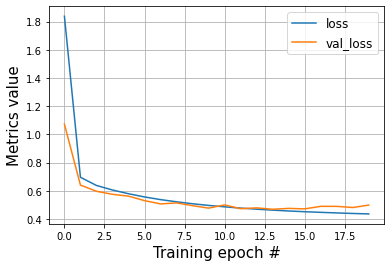

In [40]:
print(y_pred)
df = pd.DataFrame(history.history)
df.plot()
plt.grid(True)
plt.xlabel('Training epoch #', fontsize = 15)
plt.ylabel('Metrics value', fontsize = 15)
plt.legend(fontsize = 12)
plt.show()

## 3. Building Complex Models using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

<img src="./images/WideDeepNeuralNetwork.png" width="600">

Build a neural network to tackle the California housing problem.

In [41]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [42]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           930         dense_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_3[0][0]         

In [43]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 786us/step - loss: 1.8871 - val_loss: 0.9046
Epoch 2/20
363/363 [==============================] - 0s 577us/step - loss: 0.6985 - val_loss: 1.2191
Epoch 3/20
363/363 [==============================] - 0s 607us/step - loss: 0.6362 - val_loss: 0.6300
Epoch 4/20
363/363 [==============================] - 0s 608us/step - loss: 0.5831 - val_loss: 0.5406
Epoch 5/20
363/363 [==============================] - 0s 600us/step - loss: 0.5507 - val_loss: 0.5568
Epoch 6/20
363/363 [==============================] - 0s 657us/step - loss: 0.5220 - val_loss: 0.5102
Epoch 7/20
363/363 [==============================] - 0s 602us/step - loss: 0.5009 - val_loss: 0.4646
Epoch 8/20
363/363 [==============================] - 0s 656us/step - loss: 0.4829 - val_loss: 0.4541
Epoch 9/20
363/363 [==============================] - 0s 628us/step - loss: 0.4675 - val_loss: 0.4537
Epoch 10/20
363/363 [==============================] - 0s 585us/step - loss: 0.455

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

<img src="./images/MultipleInputs.png" width="600">

In [44]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [45]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
_______________________________________________________________________________________

In [46]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit({"wide_input": X_train_A, "deep_input": X_train_B}, y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate({"wide_input": X_test_A, "deep_input": X_test_B}, y_test)
y_pred = model.predict({"wide_input": X_new_A, "deep_input": X_new_B})

Epoch 1/20
363/363 [==============================] - 0s 799us/step - loss: 1.8512 - val_loss: 1.6649
Epoch 2/20
363/363 [==============================] - 0s 649us/step - loss: 0.8039 - val_loss: 0.7822
Epoch 3/20
363/363 [==============================] - 0s 637us/step - loss: 0.6764 - val_loss: 0.6340
Epoch 4/20
363/363 [==============================] - 0s 637us/step - loss: 0.6192 - val_loss: 0.5860
Epoch 5/20
363/363 [==============================] - 0s 640us/step - loss: 0.5809 - val_loss: 0.5472
Epoch 6/20
363/363 [==============================] - 0s 717us/step - loss: 0.5511 - val_loss: 0.5176
Epoch 7/20
363/363 [==============================] - 0s 639us/step - loss: 0.5268 - val_loss: 0.4939
Epoch 8/20
363/363 [==============================] - 0s 632us/step - loss: 0.5068 - val_loss: 0.4726
Epoch 9/20
363/363 [==============================] - 0s 643us/step - loss: 0.4896 - val_loss: 0.4566
Epoch 10/20
363/363 [==============================] - 0s 640us/step - loss: 0.476

## 4. Saving and Restoring a Model


When using the Sequential API or the Functional API, we want to save and re-load the model.

Keras utilizes the HDF5 format to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases). It also saves the optimizer (including its hyperparameters and any state it may have). 

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [48]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 865us/step - loss: 2.5061 - val_loss: 0.9581
Epoch 2/10
363/363 [==============================] - 0s 594us/step - loss: 0.7987 - val_loss: 0.7757
Epoch 3/10
363/363 [==============================] - 0s 592us/step - loss: 0.6655 - val_loss: 0.7126
Epoch 4/10
363/363 [==============================] - 0s 595us/step - loss: 0.6098 - val_loss: 0.5711
Epoch 5/10
363/363 [==============================] - 0s 592us/step - loss: 0.5727 - val_loss: 0.5261
Epoch 6/10
363/363 [==============================] - 0s 595us/step - loss: 0.5428 - val_loss: 0.5116
Epoch 7/10
363/363 [==============================] - 0s 796us/step - loss: 0.5192 - val_loss: 0.5018
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4997 - val_loss: 0.4606
Epoch 9/10
363/363 [==============================] - 0s 868us/step - loss: 0.4830 - val_loss: 0.4480
Epoch 10/10
162/162 [==============================] - 0s 505us/step - loss: 0.4505


In [49]:
model.save("my_keras_model.h5")

In [50]:
model = keras.models.load_model("my_keras_model.h5")

In [51]:
model.predict(X_new)

array([[0.82292956],
       [1.6101029 ],
       [3.0932832 ]], dtype=float32)

Save and load model work well when using the *Sequential API* or the *Functional API*, but unfortunately not for model subclassing. 

We can use `save_weights()` and `load_weights()` to at least save and restore the model parameters, but will need to save and restore everything else.

In [52]:
model.save_weights("my_keras_weights.ckpt")

In [53]:
model.load_weights("my_keras_weights.ckpt")

## 5. Extra reading

### Number of Hidden Layers

For many problems, you can begin with a single hidden layer and get reasonable results. An MLP with just one hidden layer can theoretically model even the most complex functions, provided it has enough neurons. But for complex problems, deep networks have a much higher parameter efficiency than shallow ones: they can model complex functions using exponentially fewer neurons than shallow nets, allowing them to reach much better performance with the same amount of training data.

To understand why, suppose you are asked to draw a forest using some drawing software, but you are forbidden to copy and paste anything. It would take an enormous amount of time: you would have to draw each tree individually, branch by branch, leaf by leaf. If you could instead draw one leaf, copy and paste it to draw a branch, then copy and paste that branch to create a tree, and finally copy and paste this tree to make a forest, you would be finished in no time. Real-world data is often structured in such a hierarchical way, and deep neural networks automatically take advantage of this fact: lower hidden layers model low-level structures (e.g., line segments of various shapes and orientations), intermediate hidden layers combine these low-level structures to model intermediate-level structures (e.g., squares, circles), and the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g., faces).

Not only does this hierarchical architecture help DNNs converge faster to a good solution, but it also improves their ability to generalize to new datasets. For example, if you have already trained a model to recognize faces in pictures and you now want to train a new neural network to recognize hairstyles, you can kickstart the training by reusing the lower layers of the first network. Instead of randomly initializing the weights and biases of the first few layers of the new neural network, you can initialize them to the values of the weights and biases of the lower layers of the first network. This way the network will not have to learn from scratch all the low-level structures that occur in most pictures; it will only have to learn the higher-level structures (e.g., hairstyles). This is called *transfer learning*.

In summary, for many problems you can start with just one or two hidden layers and the neural network will work just fine. For instance, you can easily reach above 97% accuracy on the MNIST dataset using just one hidden layer with a few hundred neurons, and above 98% accuracy using two hidden layers with the same total number of neurons, in roughly the same amount of training time. For more complex problems, you can ramp up the number of hidden layers until you start overfitting the training set. Very complex tasks, such as large image classification or speech recognition, typically require networks with dozens of layers (or even hundreds, but not fully connected ones), and they need a huge amount of training data. You will rarely have to train such networks from scratch: it is much more common to reuse parts of a pretrained state-of-the-art network that performs a similar task. Training will then be a lot faster and require much less data.


### Number of Neurons per Hidden Layer

The number of neurons in the input and output layers is determined by the type of input and output your task requires. For example, the MNIST task requires 28 × 28 = 784 input neurons and 10 output neurons.

As for the hidden layers, it used to be common to size them to form a pyramid, with fewer and fewer neurons at each layer—the rationale being that many low-level features can coalesce into far fewer high-level features. A typical neural network for MNIST might have 3 hidden layers, the first with 300 neurons, the second with 200, and the third with 100. However, this practice has been largely abandoned because it seems that using the same number of neurons in all hidden layers performs just as well in most cases, or even better; plus, there is only one hyperparameter to tune, instead of one per layer. That said, depending on the dataset, it can sometimes help to make the first hidden layer bigger than the others.

Just like the number of layers, you can try increasing the number of neurons gradually until the network starts overfitting. But in practice, it’s often simpler and more efficient to pick a model with more layers and neurons than you actually need, then use early stopping and other regularization techniques to prevent it from overfitting. 

Vincent Vanhoucke, a scientist at Google, has dubbed this the “stretch pants” approach: instead of wasting time looking for pants that perfectly match your size, just use large stretch pants that will shrink down to the right size. With this approach, you avoid bottleneck layers that could ruin your model. On the flip side, if a layer has too few neurons, it will not have enough representational power to preserve all the useful information from the inputs (e.g., a layer with two neurons can only output 2D data, so if it processes 3D data, some information will be lost). No matter how big and powerful the rest of the network is, that information will never be recovered.

### Learning Rate, Batch Size, and Other Hyperparameters

The numbers of hidden layers and neurons are not the only hyperparameters you can tweak in an MLP. Here are some of the most important ones, as well as tips on how to set them:


* *Learning rate*    
    The learning rate is arguably the most important hyperparameter. In general, the optimal learning rate is about half of the maximum learning rate (i.e., the learning rate above which the training algorithm diverges). One way to find a good learning rate is to train the model for a few hundred iterations, starting with a very low learning rate (e.g., 10-5) and gradually increasing it up to a very large value (e.g., 10). This is done by multiplying the learning rate by a constant factor at each iteration (e.g., by exp(log(106)/500) to go from 10-5 to 10 in 500 iterations). If you plot the loss as a function of the learning rate (using a log scale for the learning rate), you should see it dropping at first. But after a while, the learning rate will be too large, so the loss will shoot back up: the optimal learning rate will be a bit lower than the point at which the loss starts to climb (typically about 10 times lower than the turning point). You can then reinitialize your model and train it normally using this good learning rate.
        
            

* *Optimizer*    
    Choosing a better optimizer than plain old Mini-batch Gradient Descent (and tuning its hyperparameters) is also quite important. 

    
* *Batch size*    
    The batch size can have a significant impact on your model’s performance and training time. The main benefit of using large batch sizes is that hardware accelerators like GPUs can process them efficiently, so the training algorithm will see more instances per second. Therefore, many researchers and practitioners recommend using the largest batch size that can fit in GPU RAM. There’s a catch, though: in practice, large batch sizes often lead to training instabilities, especially at the beginning of training, and the resulting model may not generalize as well as a model trained with a smaller batch size. In April 2018, Yann LeCun even tweeted “Friends don’t let friends use mini-batches larger than 32,” citing a [2018 paper](https://arxiv.org/abs/1804.07612) by Dominic Masters and Carlo Luschi which concluded that using small batches (from 2 to 32) was preferable because small batches led to better models in less training time. Other papers point in the opposite direction, however; in 2017, papers by [Elad Hoffer et al.](https://arxiv.org/abs/1705.08741) and [Priya Goyal et al.](https://arxiv.org/abs/1706.02677) showed that it was possible to use very large batch sizes (up to 8,192) using various techniques such as warming up the learning rate (i.e., starting training with a small learning rate, then ramping it up). This led to a very short training time, without any generalization gap. So, one strategy is to try to use a large batch size, using learning rate warmup, and if training is unstable or the final performance is disappointing, then try using a small batch size instead.
    
    
* *Activation function*    
    In general, the `ReLU` activation function will be a good default for all hidden layers. For the output layer, it really depends on your task.

    
* *Number of iterations*    
    In most cases, the number of training iterations does not actually need to be tweaked: just use early stopping instead.

For more best practices regarding tuning neural network hyperparameters, check out the excellent [2018 paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.